In [1]:
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from astropy.table import Table, vstack

from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

import mcmc_binarity

# Estimating the unresolved binary fraction in nearby open clusters

This Jupyter notebook shows how to use MCMC in conjunction with a custom mixture model to estimate the unresolved binary fraction in open clusters (given a clean membership list of main-sequence members).

The main functions used are implemented in mcmc_binarity.py.

### Read cluster-member data from the Gaia EDR3 catalogue of Tarricq+2022

The data are stored in a sub-folder of the repository, one ascii file per cluster.

In [11]:
tarricqdir = "data/Tarricq_selected_members_OCs/"
files = os.listdir(tarricqdir)
print(len(files), "OCs selected")

251 OCs selected


### Run the MCMC analysis for 1 cluster

NGC_1582 : 418 stars
Maximum likelihood result: [  12.93948264    1.23912693  -28.06473138  101.92071616 -129.49545761
   72.74222775  -15.38656731]
Running MCMC...


100%|██████████| 5000/5000 [04:08<00:00, 20.09it/s]


Multiprocessing took 248.9 seconds
Mean acceptance fraction: 0.40


<Figure size 432x288 with 0 Axes>

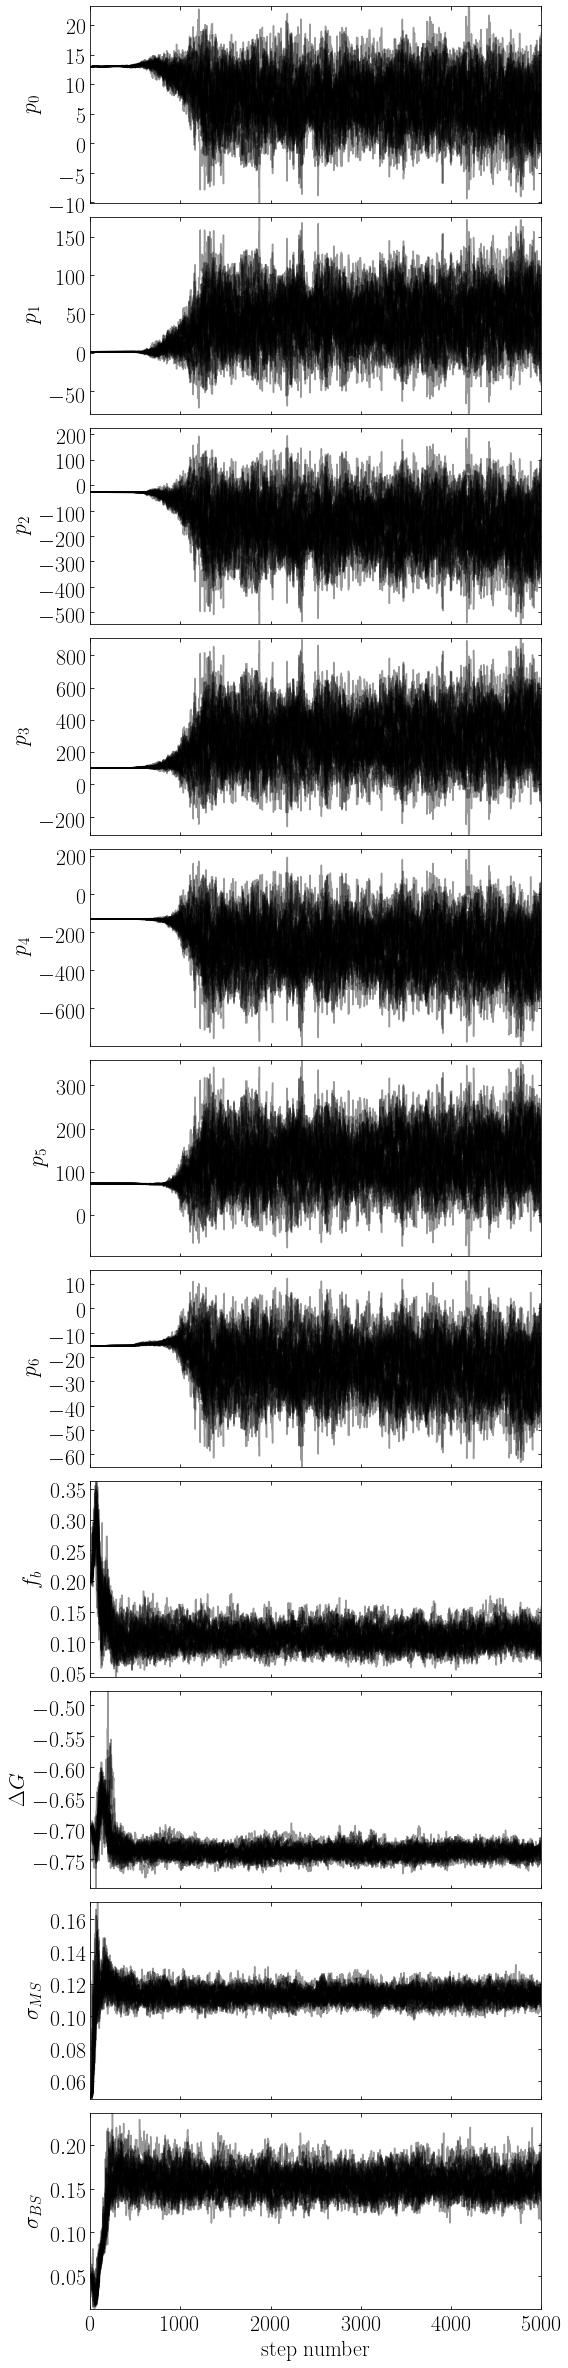

In [21]:
import time
import emcee
import corner
from multiprocessing import Pool

t = Table.read(tarricqdir + files[0], format="ascii")
x    = t["bp_rp"]
xerr = t["bp_rp_error"]
y    = t["phot_g_mean_mag"]
yerr = t["phot_g_mean_mag_error"]
clusname = files[ii][:-27]

print(clusname, ":", len(t), "stars")

# Initial guess for a MaxLikelihood fit
theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)

# Set up the MCMC sampler
nwalkers=32
nsteps=5000
burnin=1000
ndim = len(theta0)
pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

print("Running MCMC...")
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

acc_frac = np.mean(sampler.acceptance_fraction)
print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

# Get the marginalised fit parameters
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                np.round(v[2]-v[1],3), 
                                                                np.round(v[1]-v[0],3)), 
                                                     zip(*np.percentile(samples, [16, 50, 84], axis=0)))
# MCMC iteration plot
plt.clf()
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 3*ndim))
poly_labels    = ["$p_0$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$", "$p_6$", "$p_7$", "$p_8$"]
mixture_labels = ["$f_b$","$\Delta G$", "$\sigma_{MS}$", "$\sigma_{BS}$"]
labels         = poly_labels[:(ndim-4)] + mixture_labels
for ii in np.arange(ndim):
    axes[ii].plot(sampler.chain[:, :, ii].T, color="k", alpha=0.4)
    axes[ii].set_ylabel(labels[ii])
axes[ndim-1].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)

Text(0.5, 0.98, 'NGC 1582')

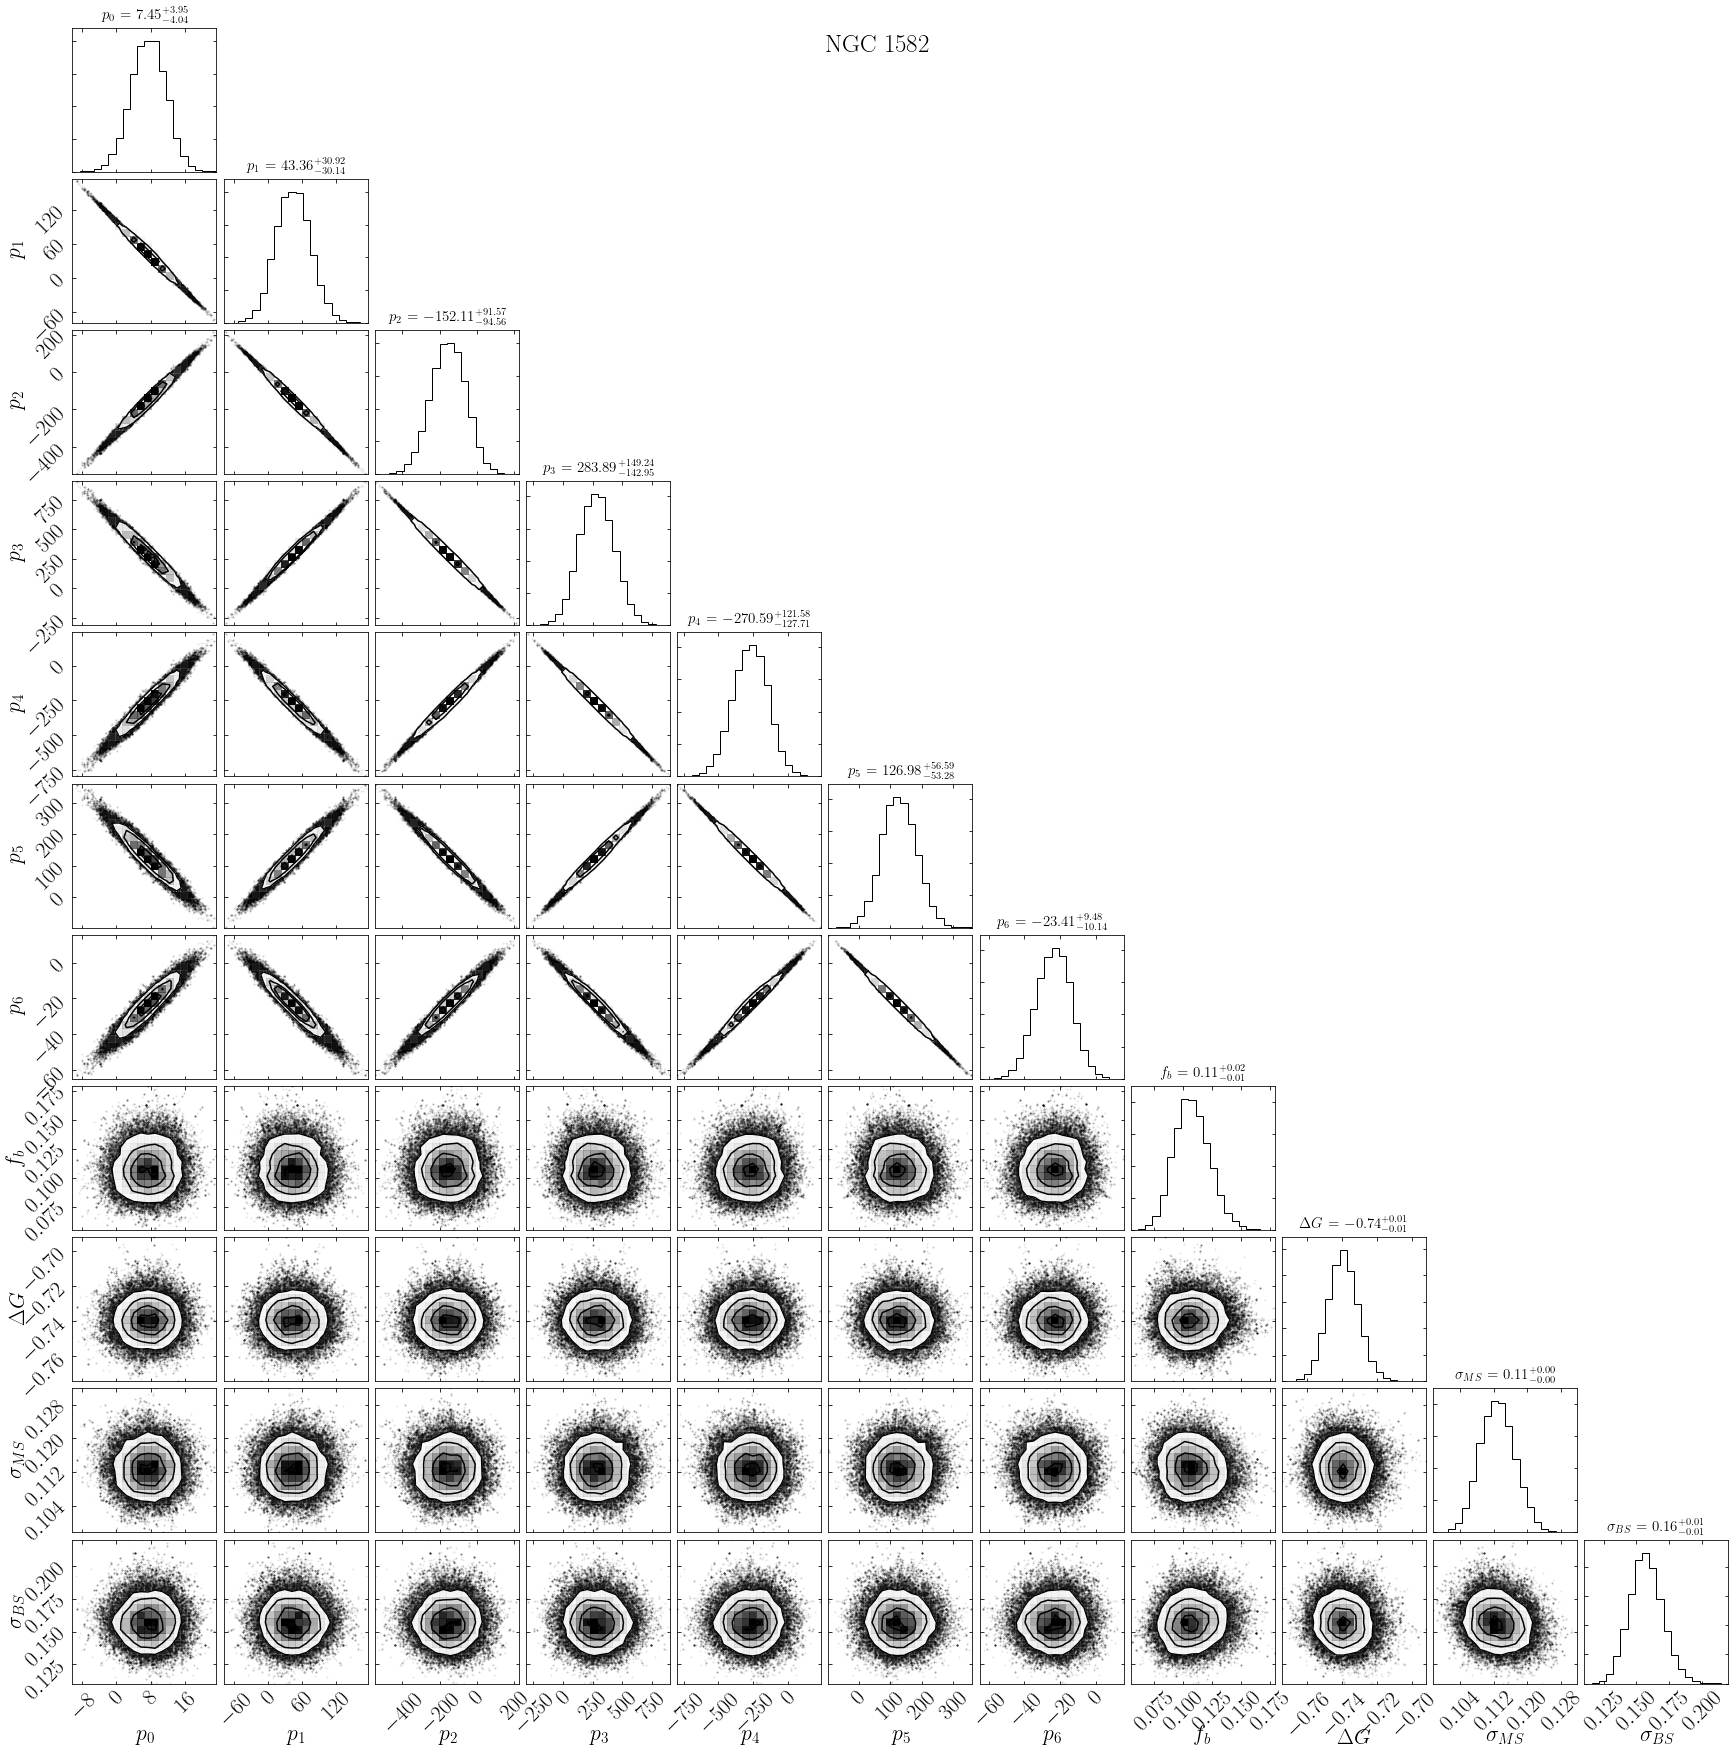

In [22]:
# Corner plot
fig = corner.corner(samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 15})
plt.suptitle(clusname.replace("_", " "), fontsize=25)

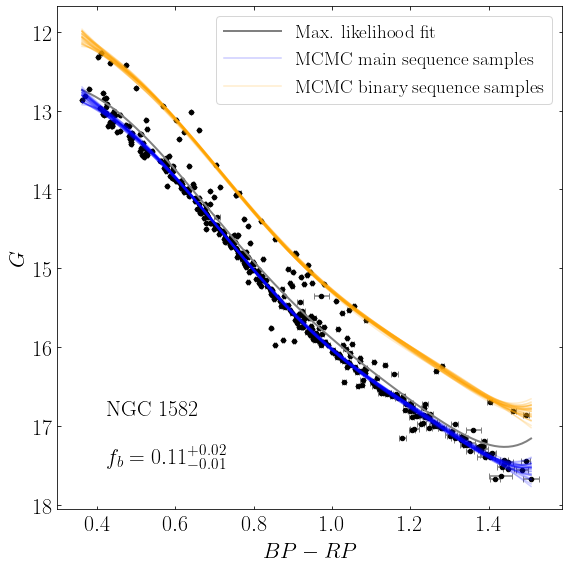

In [23]:
# CMD plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
plt.scatter(x,y, label=None, c="k")
xarr = np.linspace(np.min(x),np.max(x),100)
# Plot the maximum likelihood result.
polynom = np.poly1d(theta0[:-4][::-1])
plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
# Plot some MCMC samples onto the data.
for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
    bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
    plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
# Plot the best-parameter result.
#polynom = np.poly1d([p6_m[0],p5_m[0],p4_m[0],p3_m[0],p2_m[0],p1_m[0],p0_m[0]])
plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
plt.xlabel(r"$BP-RP$", fontsize=22)
plt.ylabel(r"$G$", fontsize=22)
plt.legend(loc="upper right", fontsize=19)
# Annotate name of the cluster and binary fraction
ax = plt.gca()
plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, fontsize=22)
plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
ax.invert_yaxis()
plt.tight_layout()

### Example of a loop over clusters

In [5]:
# Just looping over the first 3 clusters
# If you want to run for all, use mcmc_binarity.py or replace the following line by
# for ii in np.arange(len(files)):
for ii in [0,1,2]:
    t = Table.read(tarricqdir + files[ii], format="ascii")
    x    = t["bp_rp"]
    xerr = t["bp_rp_error"]
    y    = t["phot_g_mean_mag"]
    yerr = t["phot_g_mean_mag_error"]
    clusname = files[ii][:-27]

    print(clusname, ":", len(t), "stars")
    
    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Now run MCMC
    result = mcmc_binarity.run_mcmc(x, y, xerr, yerr, theta0, nwalkers=32, nsteps=5000, burnin=500,
                                    plotdir="im_mcmc/im_mcmc_tarricq/", clusname=clusname, save_results=False)

    # Save the results
    if ii == 0:
        restable = result
    else:
        if result == None:
            pass
        else:
            restable = vstack([restable, result])
    restable.write("data/mcmc_results_tarricq_summary_test.fits", overwrite=True)

NGC_2539 : 418 stars
Maximum likelihood result: [  12.93948264    1.23912693  -28.06473138  101.92071616 -129.49545761
   72.74222775  -15.38656731]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.23it/s]


Multiprocessing took 225.0 seconds
Mean acceptance fraction: 0.40
Melotte_22 : 1158 stars
Maximum likelihood result: [ 6.96218491  3.12858113 -0.28563707  3.05922272 -2.87269688  0.94208868
 -0.1043249 ]
Running MCMC...


100%|██████████| 5000/5000 [04:28<00:00, 18.63it/s]


Multiprocessing took 268.4 seconds
Mean acceptance fraction: 0.41
UPK_90 : 47 stars
Maximum likelihood result: [-2.42943713e-01  7.96579234e+01 -2.33114028e+02  3.78413264e+02
 -3.35108059e+02  1.51463497e+02 -2.71663865e+01]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.94it/s]


Multiprocessing took 228.0 seconds
Mean acceptance fraction: 0.32


<Figure size 432x288 with 0 Axes>